### Récupération du dataset

In [1]:
import numpy as np
import pandas as pd
import lifelines

df = lifelines.datasets.load_lung()

display(df.head())

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,1,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,1,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,0,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,1,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,1,60,1,0.0,100.0,90.0,NaN,0.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       227 non-null    float64
 1   time       228 non-null    int64  
 2   status     228 non-null    int64  
 3   age        228 non-null    int64  
 4   sex        228 non-null    int64  
 5   ph.ecog    227 non-null    float64
 6   ph.karno   227 non-null    float64
 7   pat.karno  225 non-null    float64
 8   meal.cal   181 non-null    float64
 9   wt.loss    214 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 17.9 KB


### Gestion des doublons et valeurs manquantes

In [3]:
print (df.duplicated().sum())
# Pas de doublons

# Inst : remplacer les valeurs manquantes par la valeur la plus fréquente
df['inst'] = df['inst'].fillna(df['inst'].mode()[0])

# Valeurs numériques : remplacer par la médiane
float_cols = ['ph.ecog','ph.karno','pat.karno','meal.cal','wt.loss']
df[float_cols] = df[float_cols].fillna(df[float_cols].median())

df.isna().sum()

0


inst         0
time         0
status       0
age          0
sex          0
ph.ecog      0
ph.karno     0
pat.karno    0
meal.cal     0
wt.loss      0
dtype: int64

### Vérification de la validité des données

In [4]:
# Vérifier la distribution des données catégorielles
print (df['inst'].value_counts())
print(df['status'].value_counts())
print(df['sex'].value_counts())

# inst qui est très déséquilibrée => on va faire un encodage fréquentiel 
df['inst'] = df['inst'].map(df['inst'].value_counts(normalize=True))

# Sexe : on passe de 1/2 à 1/0
df['sex'] = df['sex'].replace({2:0})

inst
1.0     37
12.0    23
13.0    20
3.0     19
11.0    18
22.0    17
16.0    16
6.0     14
21.0    13
5.0      9
7.0      8
32.0     7
26.0     6
15.0     6
2.0      5
4.0      4
10.0     4
33.0     2
Name: count, dtype: int64
status
1    165
0     63
Name: count, dtype: int64
sex
1    138
2     90
Name: count, dtype: int64


C:\Users\maxbe\AppData\Local\Temp\ipykernel_7948\578155948.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(x=df[col],labels=[col])
C:\Users\maxbe\AppData\Local\Temp\ipykernel_7948\578155948.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(x=df[col],labels=[col])
C:\Users\maxbe\AppData\Local\Temp\ipykernel_7948\578155948.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(x=df[col],labels=[col])
C:\Users\maxbe\AppData\Local\Temp\ipykernel_7948\578155948.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; 

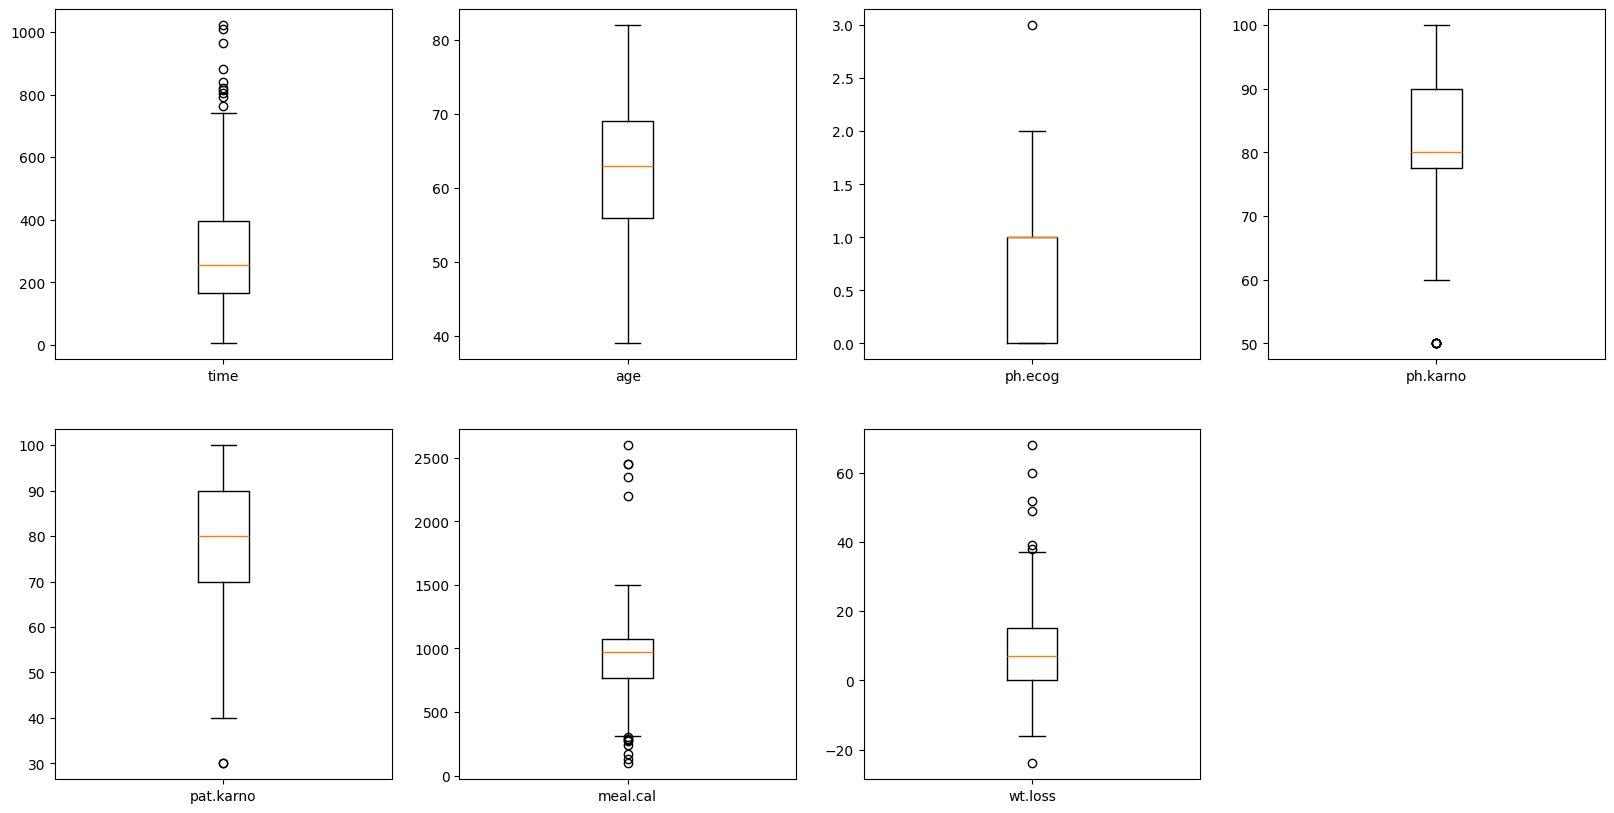

In [5]:
# Vérifier la distribution des données quantitatives 
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
for i,col in enumerate(['time','age','ph.ecog','ph.karno','pat.karno','meal.cal','wt.loss']):
    plt.subplot(241+i)
    plt.boxplot(x=df[col],labels=[col])
plt.show()

# Les données semblent cohérentes

### Relations entre les données

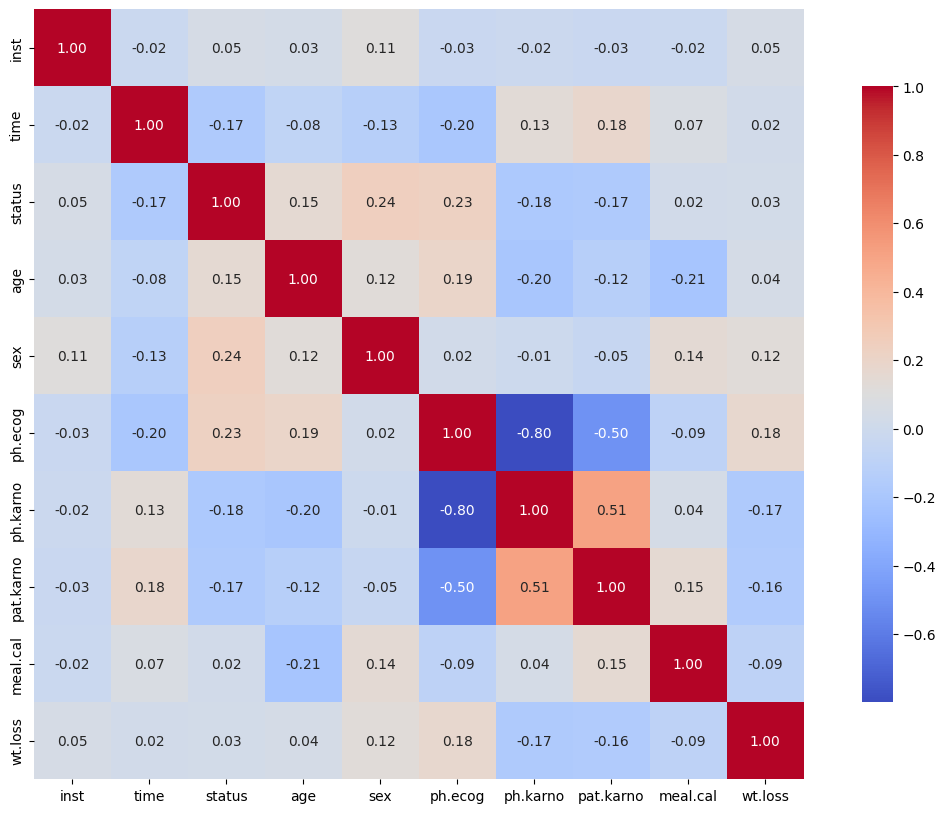

In [6]:
import seaborn as sns

plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm',square=True,cbar_kws={"shrink": .8})
plt.show()

# Le ph ecog et le sexe semblent avoir une corrélation relativement plus forte avec le décès du patient

### Analyse de survie avec statsmodels

#### Régression Cox

In [22]:
# Avac statsmodels, pas d'ensemble d'entraînement et de test => on fait de l'analyse statistique, pas de la prédiction
T= df['time']
E = df['status']
X = df.drop(['time','status'],axis=1)

# Standardiser les variables explicatives continues
from sklearn.preprocessing import StandardScaler
col_to_standardize = ['age','ph.ecog','ph.karno','pat.karno','meal.cal','wt.loss']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[col_to_standardize])

X_scaled = pd.DataFrame(X_scaled,index = X.index,columns=col_to_standardize)
X = pd.concat([X.drop(col_to_standardize,axis=1),X_scaled],axis=1)

# Ajout d'une constante pour ordonnée à l'origine dans le modèle de Cox
import statsmodels.api as sm
X = sm.add_constant(X)

display(X)

,const,inst,sex,age,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,1.0,0.083333,1,1.276035,0.067502,0.657478,1.382875,0.661467,-0.208979
1,1.0,0.083333,1,0.613311,-1.331639,0.657478,0.692951,0.801198,0.420026
2,1.0,0.083333,1,-0.712138,-1.331639,0.657478,0.692951,0.102543,0.420026
3,1.0,0.039474,1,-0.601684,0.067502,0.657478,-1.376823,0.591601,0.105524
4,1.0,0.162281,1,-0.270322,-1.331639,1.472180,0.692951,0.102543,-0.759358
...,...,...,...,...,...,...,...,...,...
223,1.0,0.162281,1,1.607397,0.067502,-0.157223,-1.376823,0.102543,-0.523481
224,1.0,0.087719,1,-2.589857,-1.331639,0.657478,0.692951,3.945145,-1.152486
225,1.0,0.030702,0,1.386489,1.466644,-1.786626,-0.686899,0.242274,-0.366230
226,1.0,0.061404,1,0.392403,0.067502,0.657478,1.382875,0.382005,-0.680733


In [23]:

from statsmodels.duration.hazard_regression import PHReg

# Modèle de Cox à risque proportionnel
cox = PHReg(T,X,E)
results = cox.fit()
display(results.summary())

d:\Sources\DS-Machine-Learning\AdvancedML\env\Lib\site-packages\statsmodels\duration\hazard_regression.py:1423: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: PHReg
================================================================
Model:                      PH Reg        Sample size:       228
Dependent variable:         time          Num. events:       165
Ties:                       Breslow                             
----------------------------------------------------------------
           log HR log HR SE   HR      t    P>|t|  [0.025  0.975]
----------------------------------------------------------------
const     -0.0000       nan 1.0000     nan    nan    nan     nan
inst       1.8597    1.1265 6.4221  1.6509 0.0988 0.7060 58.4174
sex        0.5848    0.1404 1.7946  4.1646 0.0000 1.3628  2.3631
age        0.1100    0.0856 1.1163  1.2847 0.1989 0.9438  1.3203
ph.ecog    0.4268    0.1307 1.5324  3.2662 0.0011 1.1861  1.9797
ph.karno   0.1705    0.1149 1.1859  1.4839 0.1378 0.9468  1.4854
pat.karno -0.1844    0.0993 0.8316 -1.8573 0.0633 0.6846  1.0102
meal.cal   0.0055    0.0872 1.0055  0.0631 0.9497 0.8476  1.1929
wt.loss   -0.1518    0.0837 0.8591 -1.8129 0.0698 0.7291  1.0124
================================================================
Confidence intervals are for the hazard ratios
"""

✅ Sexe et ph.ecog sont significatifs et influencent clairement la survie.

❌ inst n’est pas significatif, mais HR=6.42 est très élevé → il faut vérifier son impact.

🔍 pat.karno et wt.loss sont proches du seuil de significativité → pourraient être pertinents avec plus de données.

⚠️ Les autres variables (âge, ph.karno, meal.cal) n’ont pas d’effet clair sur la survie.

In [33]:
# Calcul de l'indice de concordance
from lifelines.utils import concordance_index
# concordance_index attend un score où une valeur plus grande signifie une meilleure survie => inverser le signe de la prédiction
risk_scores = results.predict().predicted_values
c_index = concordance_index(T,-risk_scores,E)
print(f"Indice de concordance (C-index) : {c_index:.4f}")

Indice de concordance (C-index) : 0.6551


#### Courbe de survie (Kaplan-Meier)

In [25]:
# Fonction de survie et intervalle de confiance à 95%
sf = sm.duration.SurvfuncRight(T,E)
cb = sf.simultaneous_cb()

cb = pd.DataFrame({"[0.025":cb[0],"0.975]":cb[1]},index=sf.summary().index)
display(pd.concat([sf.summary(),cb],axis=1))

,Surv prob,Surv prob SE,num at risk,num events,[0.025,0.975]
Time,,,,,,
5,0.995614,0.004376,228,1.0,0.000000,1.000000
11,0.982456,0.008695,227,3.0,0.042621,0.999901
12,0.978070,0.009699,224,1.0,0.233880,0.999662
13,0.969298,0.011425,223,2.0,0.532254,0.998459
15,0.964912,0.012186,221,1.0,0.603829,0.997474
...,...,...,...,...,...,...
735,0.097894,0.026597,12,1.0,0.040995,0.184406
765,0.088105,0.025675,10,1.0,0.034437,0.173462
791,0.078315,0.024618,9,1.0,0.028341,0.161943


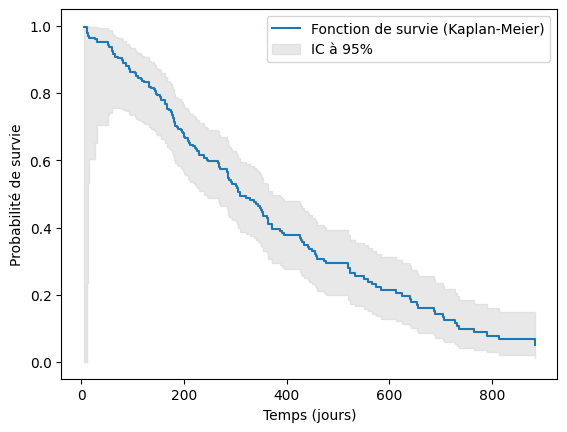

In [26]:
# Afficher la fonction de survie et l'intervalle de confiance
plt.step(sf.surv_times, sf.surv_prob, where="post", label="Fonction de survie (Kaplan-Meier)")
plt.fill_between(sf.surv_times, cb["[0.025"], cb["0.975]"], step="post", color='lightgray', alpha=0.5, label="IC à 95%")

# Ajout des titres et labels
plt.xlabel('Temps (jours)')
plt.ylabel('Probabilité de survie')
plt.legend()
plt.show()

### Analyse de survie avec scikit-survival

#### Modèle Random Survival Forest

In [28]:
from sklearn.model_selection import train_test_split
from sksurv.util import Surv

# Séparation feature et targets
T= df['time']
E = df['status']
X = df.drop(['time','status'],axis=1)

# Créer un array structuré pour y avec sksurv.util.Surv
y = Surv.from_arrays(E, T)

# Séparation entraînement et test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

# Standardiser les variables explicatives continues
col_to_standardize = ['age','ph.ecog','ph.karno','pat.karno','meal.cal','wt.loss']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[col_to_standardize])
X_test_scaled = scaler.transform(X_test[col_to_standardize])

X_train_scaled = pd.DataFrame(X_train_scaled,index = X_train.index,columns=col_to_standardize)
X_train = pd.concat([X_train.drop(col_to_standardize,axis=1),X_train_scaled],axis=1)

X_test_scaled = pd.DataFrame(X_test_scaled,index = X_test.index,columns=col_to_standardize)
X_test = pd.concat([X_test.drop(col_to_standardize,axis=1),X_test_scaled],axis=1)

In [ ]:
# Modèle RandomSurvivalForest
from sksurv.ensemble import RandomSurvivalForest
rsf = RandomSurvivalForest(n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=42)
rsf.fit(X_train,y_train)

# Evaluation index de concordance
print ("C-index :", rsf.score(X_test,y_test))

# La prédiction du modèle est correcte

C-index : 0.6619828259172521


In [37]:
# Estimer l'importance des caractéristiques par permutation
from sklearn.inspection import permutation_importance
result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=42)
importance_df = pd.DataFrame(
    {
        k: result[k] for k in ("importances_mean","importances_std")
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

display(importance_df)

,importances_mean,importances_std
sex,0.047307,0.011883
pat.karno,0.035441,0.021691
ph.ecog,0.022899,0.034677
inst,0.011918,0.009396
wt.loss,0.006089,0.006324
age,0.001821,0.012450
meal.cal,-0.001665,0.004236
ph.karno,-0.002706,0.013068


#### Prédiction de survie sur des groupes test

In [ ]:
# On va extraire les 5 patients masculins avec le plus grand ph.ecog
X_test_safe = X_test.loc[X_test['sex']==1].sort_values(by=["ph.ecog"],ascending=False).head(5)

# On va extraire les 5 patientes avec le plus petit ph.ecog
X_test_unsafe = X_test.loc[X_test['sex']==0].sort_values(by=["ph.ecog"],ascending=True).head(5)

# On prédit leur score de risque
X_test_sel = pd.concat([X_test_safe, X_test_unsafe])
risk_scores = pd.DataFrame(rsf.predict(X_test_sel),index = X_test_sel.index, columns=['Risk score'])

# On affiche le résultat sous forme de dataframe
display(pd.concat([X_test_sel,risk_scores],axis=1))

# On constate clairement un score de risque différent entre ces 2 groupes

,inst,sex,age,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,Risk score
65,0.083333,1,0.599045,1.446728,-0.966229,-2.046234,-0.305700,-0.142918,109.334387
205,0.008772,1,-0.041184,1.446728,-0.160253,-0.684732,0.093222,-0.224653,105.867014
157,0.017544,1,-0.041184,1.446728,-0.966229,-1.365483,-1.236519,1.410056,106.419109
34,0.100877,1,-0.147889,1.446728,-0.966229,1.357521,0.359170,0.020553,96.850105
190,0.070175,1,1.025865,0.072336,-0.160253,0.676770,-1.201946,0.347495,93.916631
42,0.017544,0,-0.361299,-1.302056,0.645724,0.676770,-1.534381,1.410056,60.586191
204,0.026316,0,0.065521,-1.302056,1.451700,0.676770,-1.401407,-0.796801,60.576447
198,0.162281,0,-1.108233,-1.302056,1.451700,-0.003981,0.093222,-0.796801,59.813339
94,0.162281,0,0.705750,-1.302056,1.451700,0.676770,0.093222,0.265760,64.594448
67,0.039474,0,0.172225,-1.302056,0.645724,-0.684732,0.226196,-0.551595,77.340634


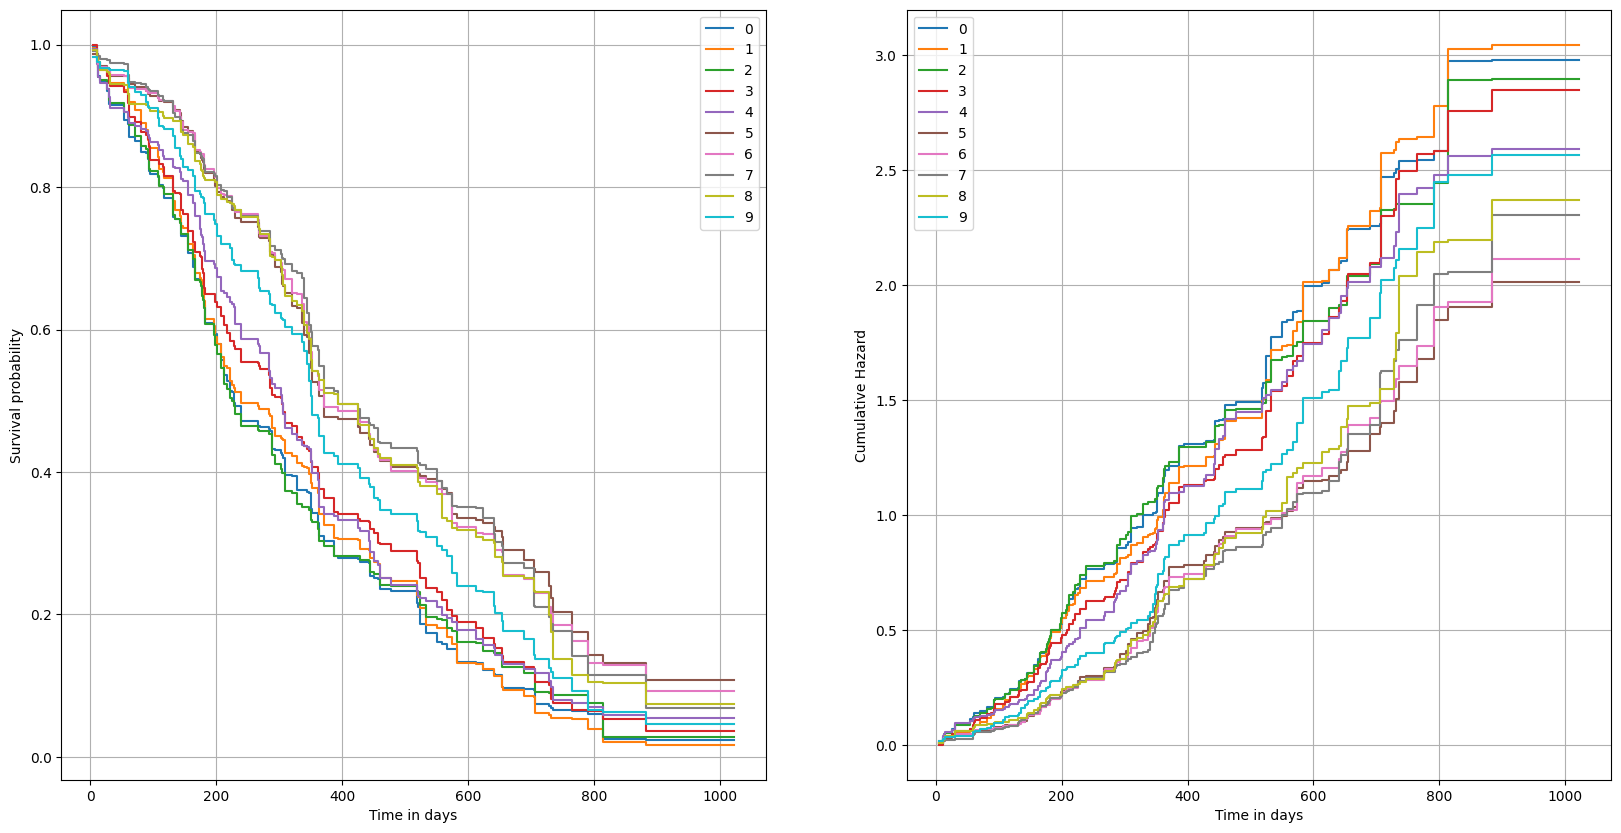

In [ ]:
plt.figure(figsize=(20,10))

# Prédire les fonctions de survie
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

plt.subplot(121)
for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

# Prédire les fonctions de risque cumulatif
cum_hazard = rsf.predict_cumulative_hazard_function(X_test_sel,return_array=True)

plt.subplot(122)
for i, s in enumerate(cum_hazard):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative Hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)
plt.show()

# On constate que le second groupe encourt moins de risque et a une meilleure survie globale au cours du temps